# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [69]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

After transforming initial formula we get equation below 

$$\nabla_w L = X^T(\hat Y - Y ) +  [sign(w_i)*\gamma] + [2w_i*\beta]$$ 

<br> Where $$\hat Y^ =  \sigma(Xw)  $$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [70]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [71]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    m,n = X.shape
    z = np.dot(X, w)
    y_heat = sigmoid(z)
    
    return -(np.dot(np.transpose(y),np.log(y_heat)) + np.dot(1 - np.transpose(y),np.log(1 - y_heat))) + gamma * np.sum(w) + beta * np.sum(w**2)

#### 3. [0.25 points] Implement the gradient (as a function)

In [72]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    m,n = X.shape
    z = np.dot(X, w)
    y_heat = sigmoid(z)
    gradient = np.dot(X.T, (y_heat - y)) + beta * 2 * w + gamma * np.sign(w)
    return gradient

#### Check yourself

In [73]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)


grad_w = get_grad(X, y, w)

assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [74]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [315]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        # you may additional properties if you wish

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps

        self.loss_history = []

        X = np.c_[np.ones(X.shape[0]), X]

        n, d = X.shape

        self.w = np.random.randn(d)

        for _ in range(self.max_iter):                
                self.loss_history.append(loss(X,y,self.w,self.gamma,self.beta))

                diff = self.lr * get_grad(X,y,self.w,self.gamma,self.beta)

                self.w -=  diff

                if np.linalg.norm(diff) < self.tolerance:
                    break

        return self


    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here

        if self.w is None:
            raise Exception('Not trained yet')
        
        X = np.c_[np.ones(X.shape[0]), X]

        z = np.dot(X,self.w)

        probs = np.array(sigmoid(z))
        
        threshold = 0.5

        predict = np.where(probs >= threshold, 1, 0)        

        return predict 

    def predict_proba(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        z = np.dot(X,self.w)
        probabilities = sigmoid(z)
        return np.column_stack((1 - probabilities, probabilities))

In [178]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)


In [77]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

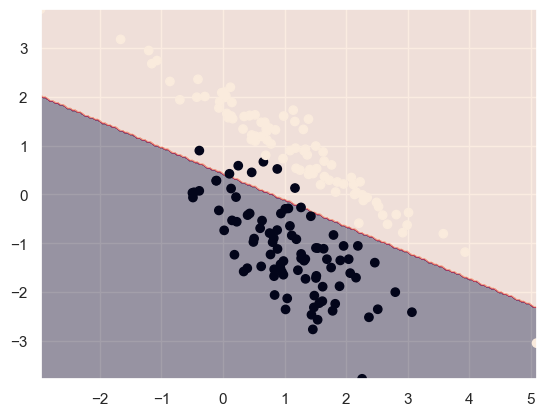

In [78]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

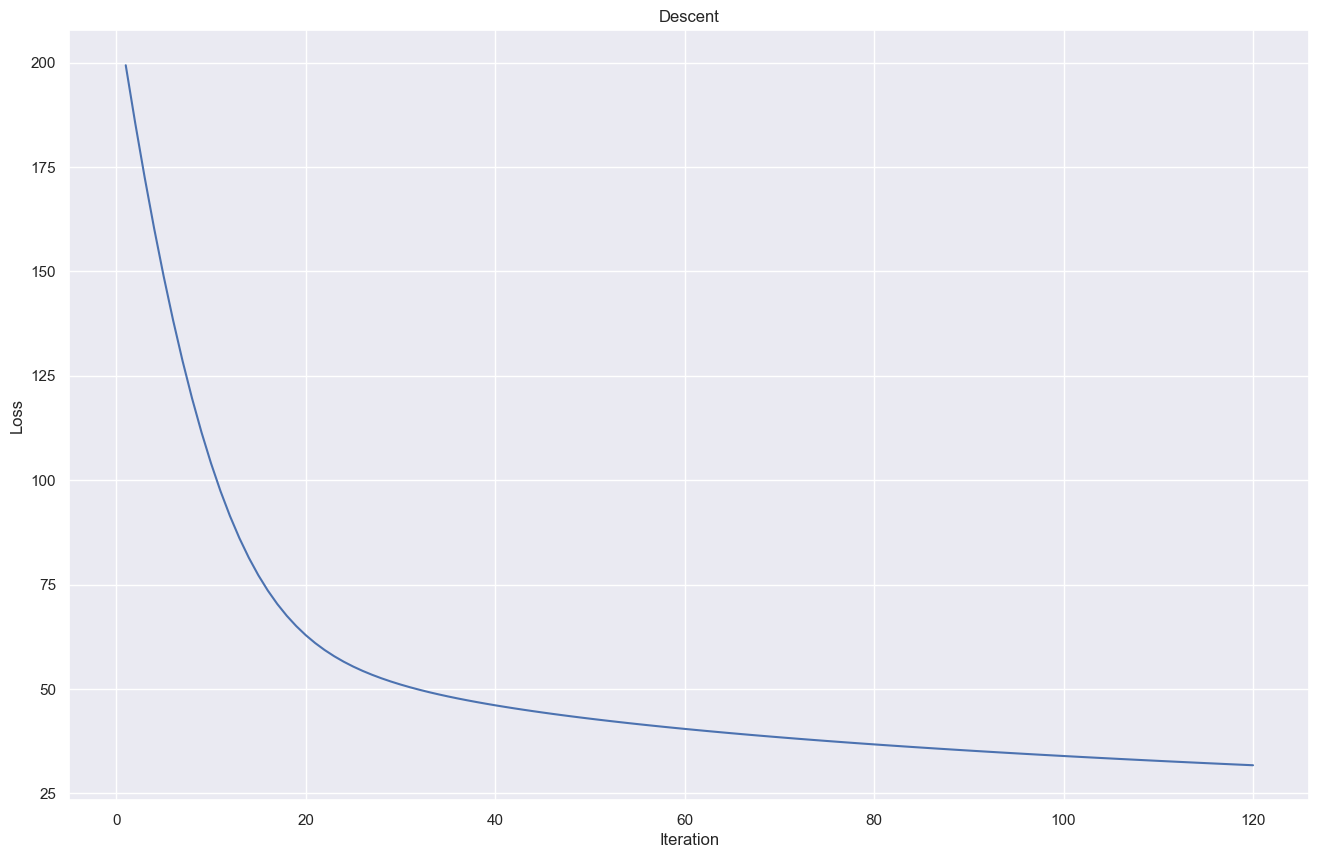

In [79]:
size = len(model.loss_history)
x_size = range(1,size+1)

plt.figure(figsize = (16,10))
plt.plot(x_size,model.loss_history,color = 'b')
plt.title('Descent')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [223]:
# I stole code below from sixth seminar



# a function to plot the decision boundary
def plot_decision_boundary_modified(model, X, y, params):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(params)

Exception ignored in: <function tqdm.__del__ at 0x000002E8E49E0360>
Traceback (most recent call last):
  File "C:\Users\aslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "C:\Users\aslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


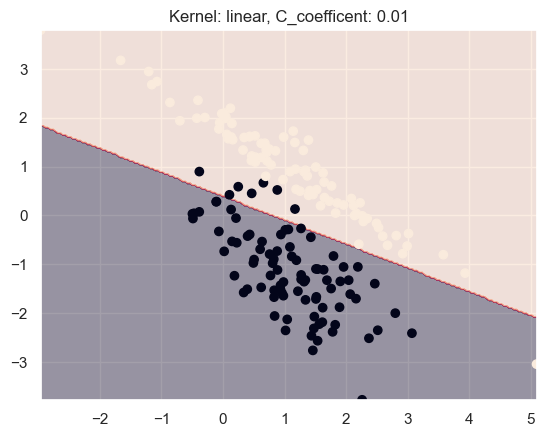

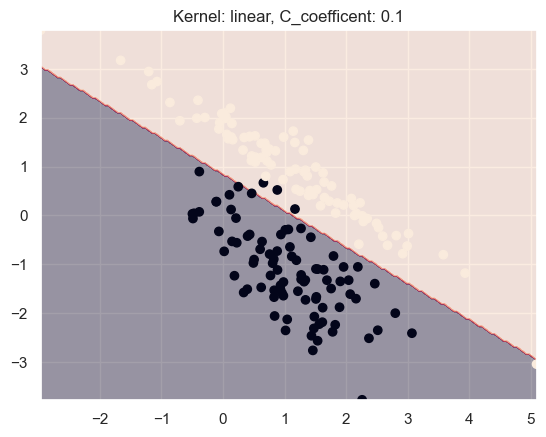

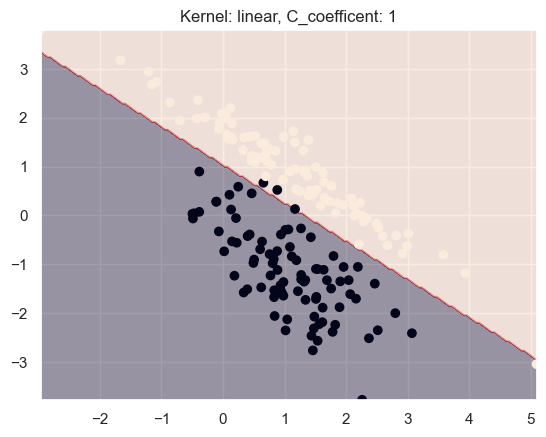

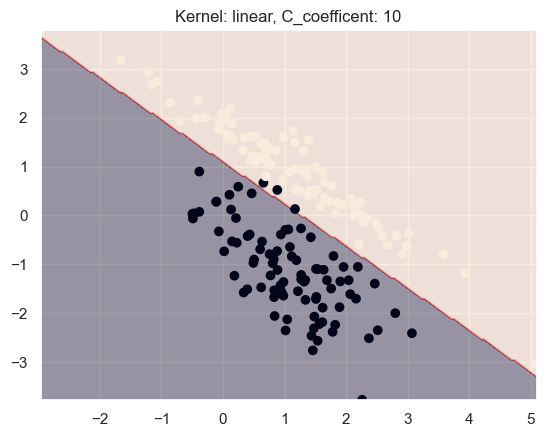

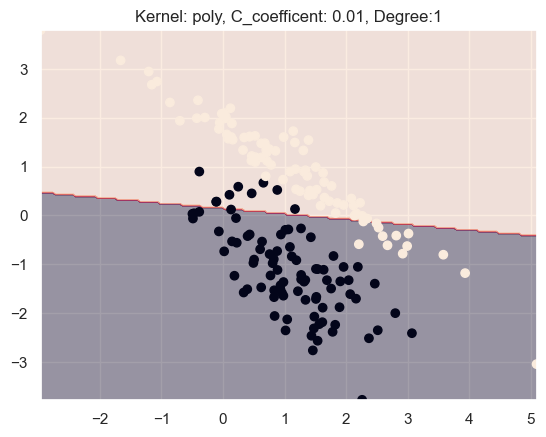

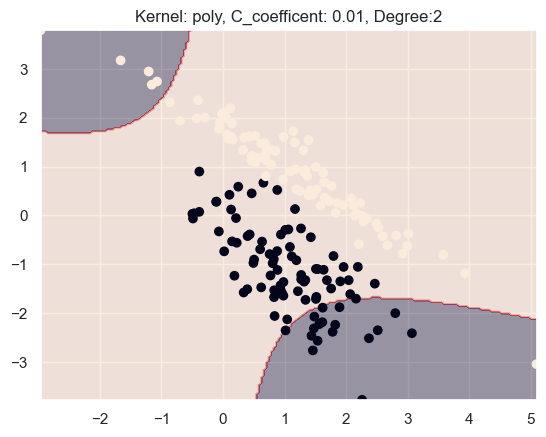

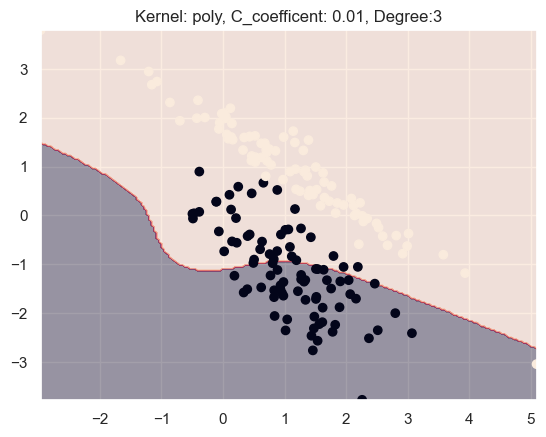

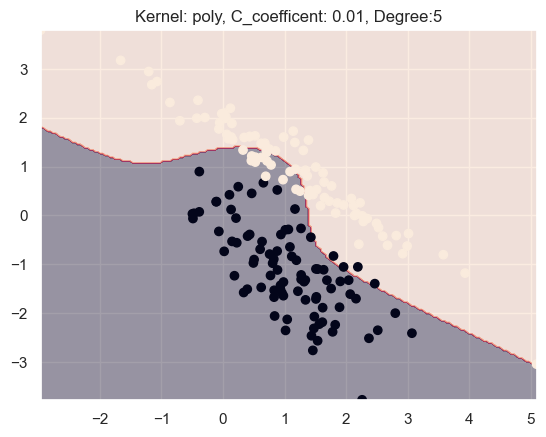

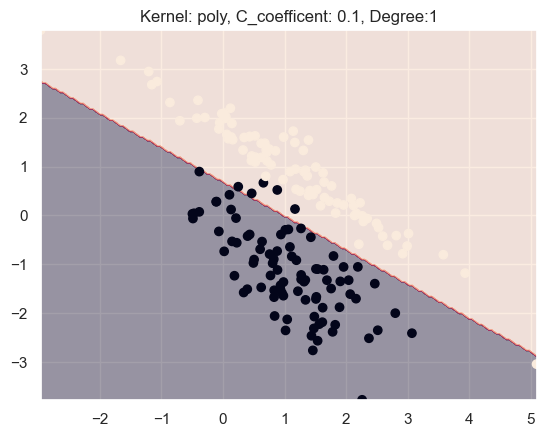

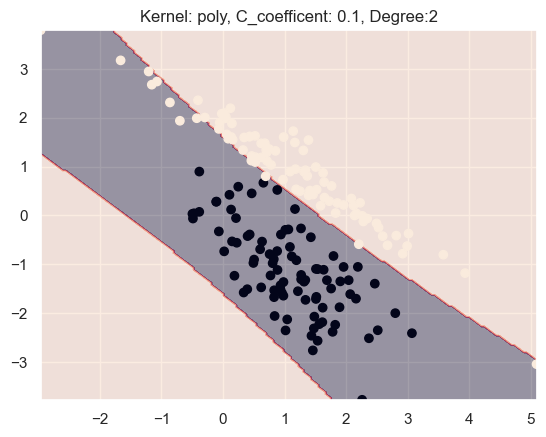

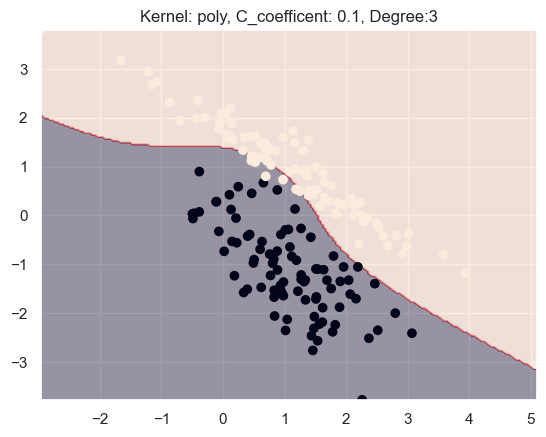

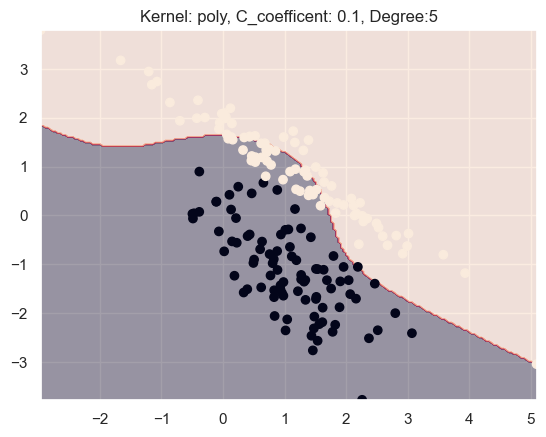

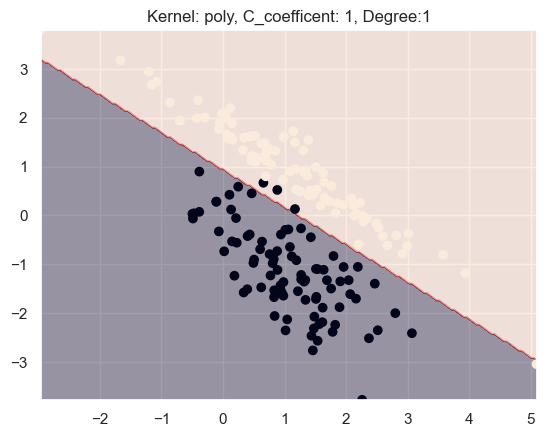

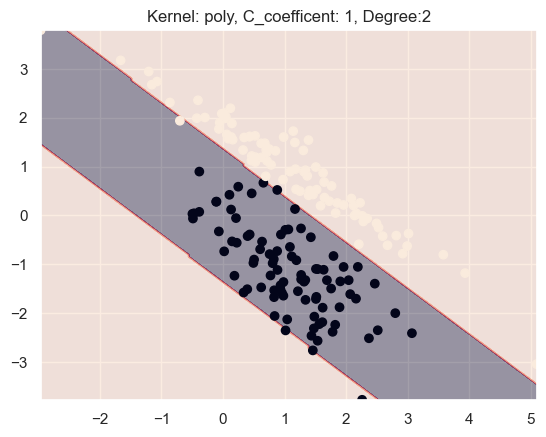

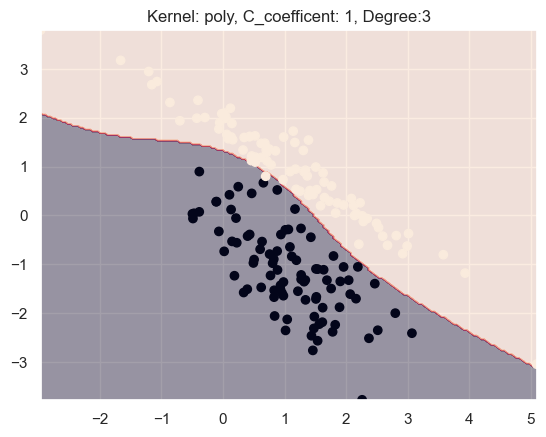

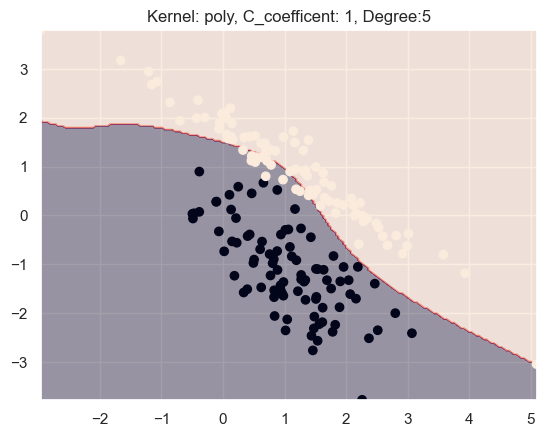

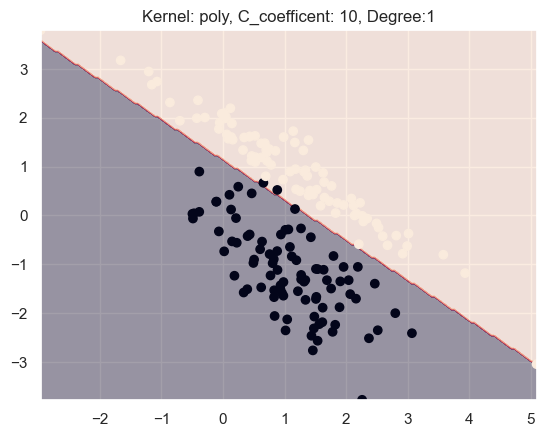

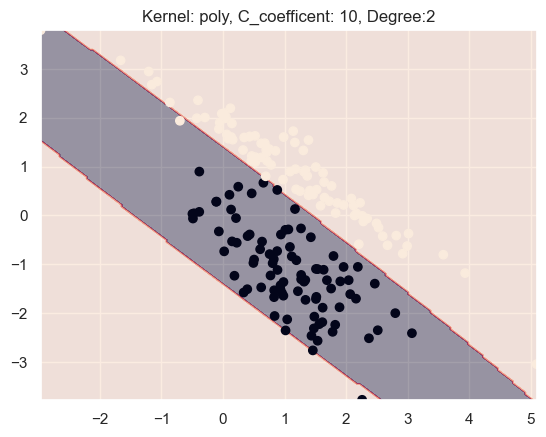

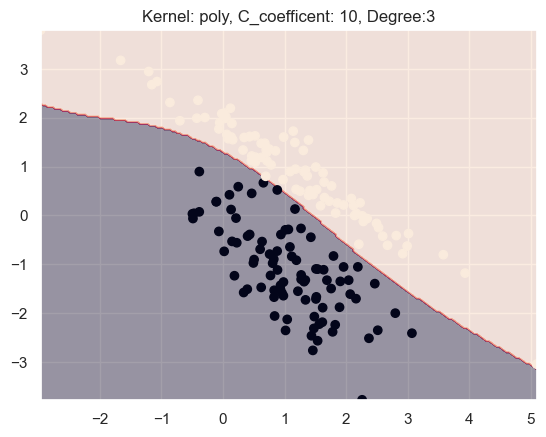

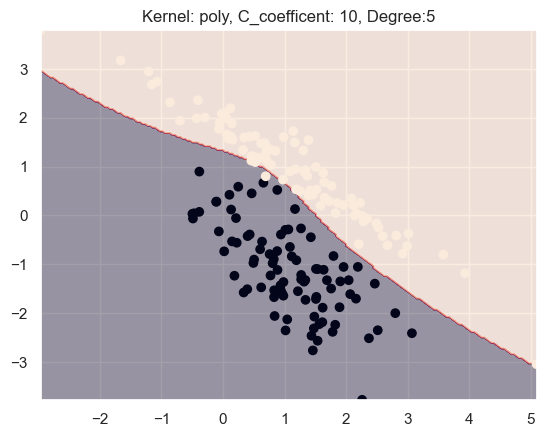

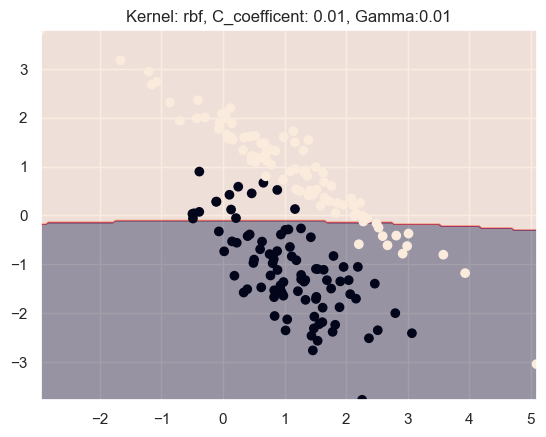

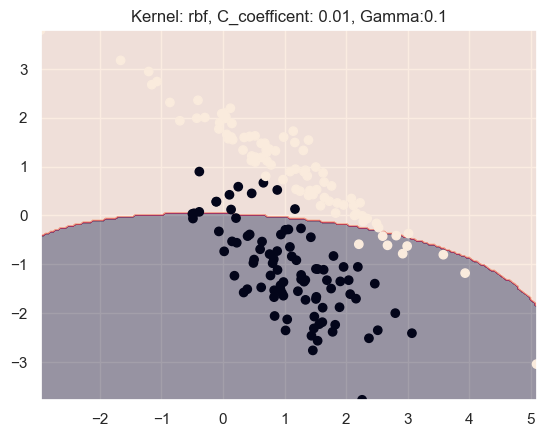

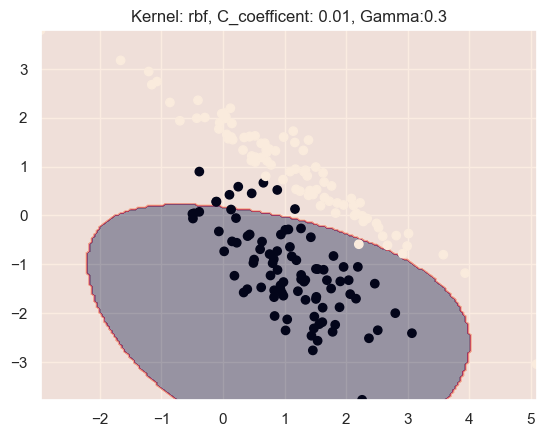

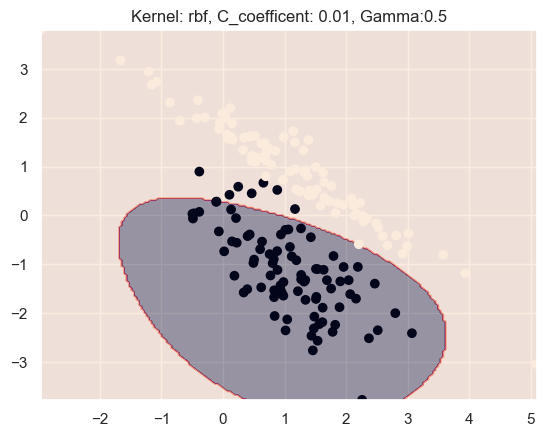

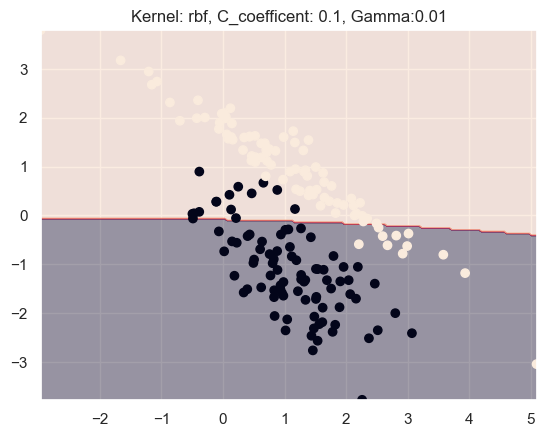

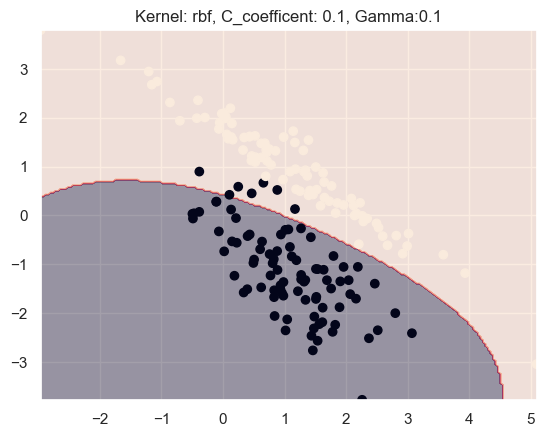

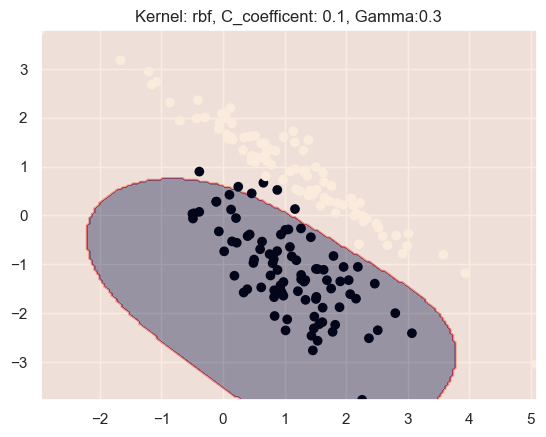

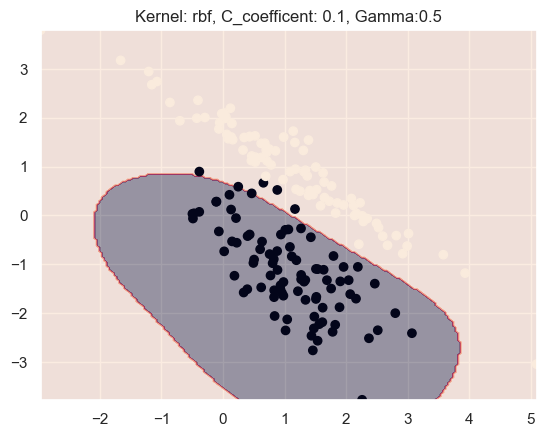

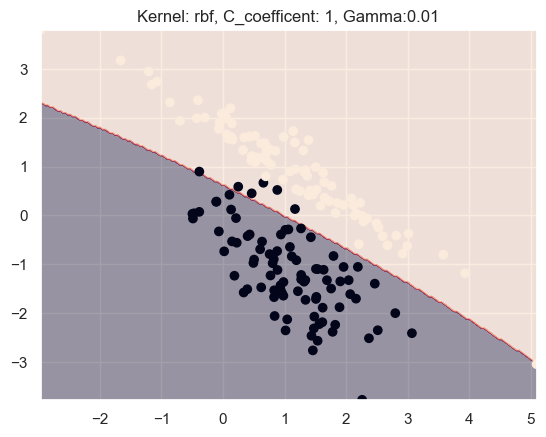

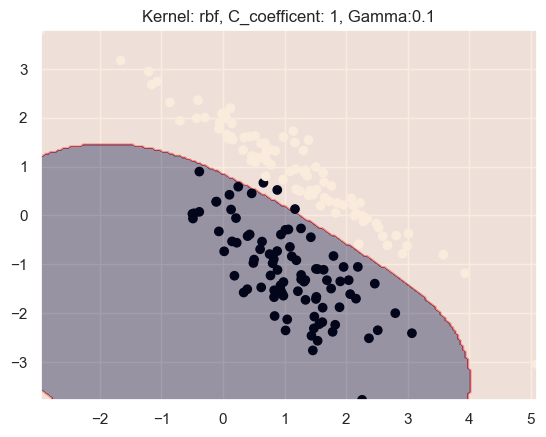

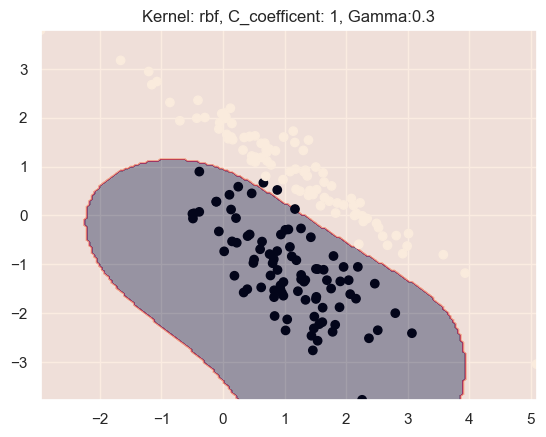

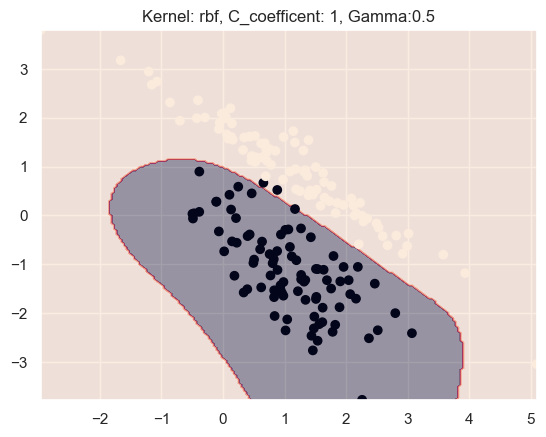

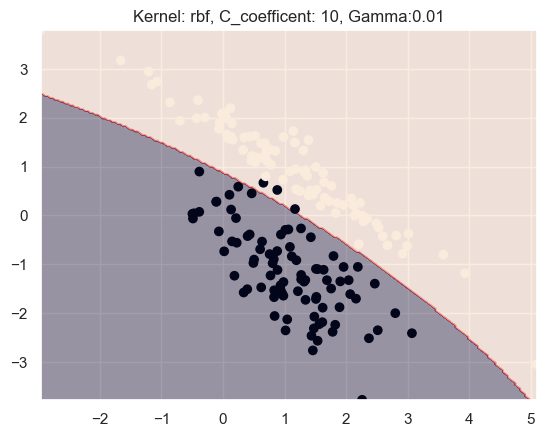

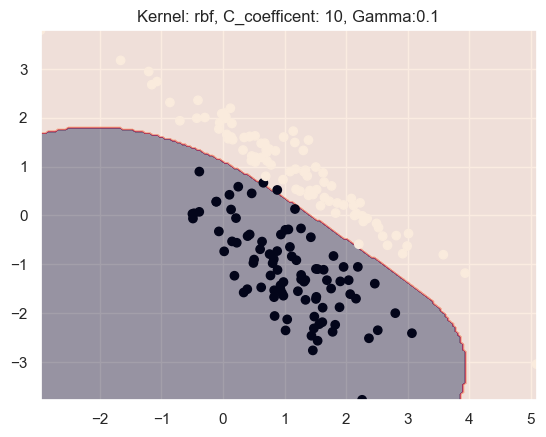

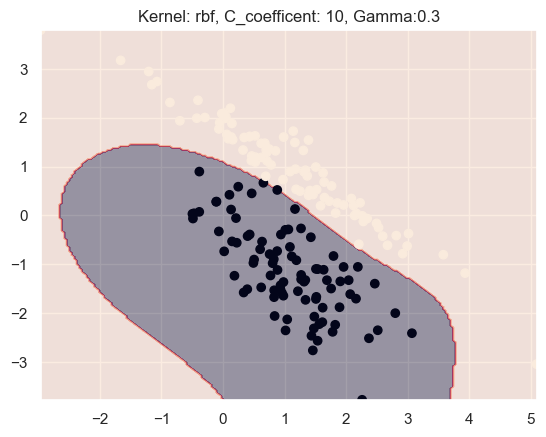

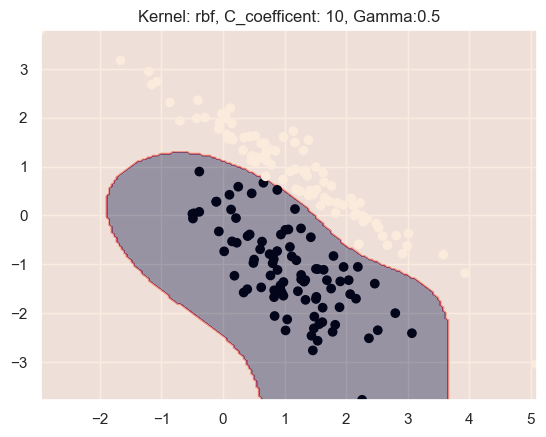

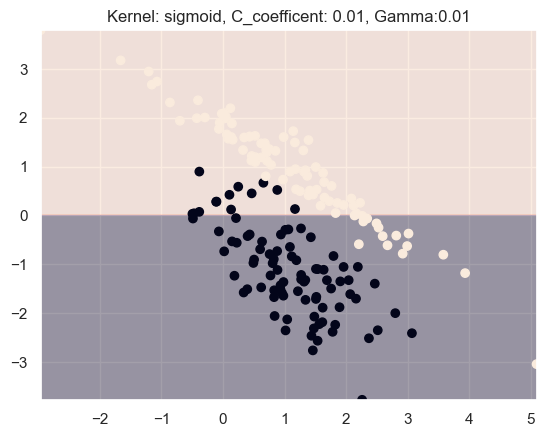

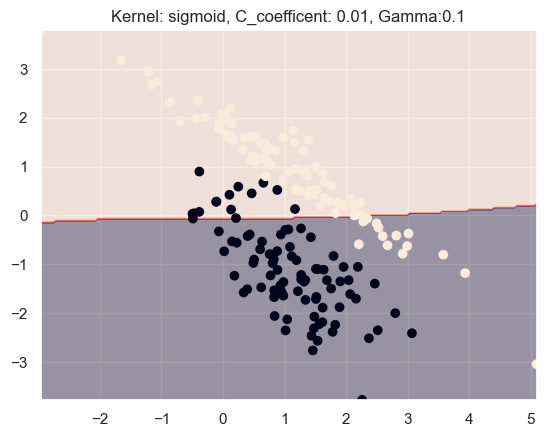

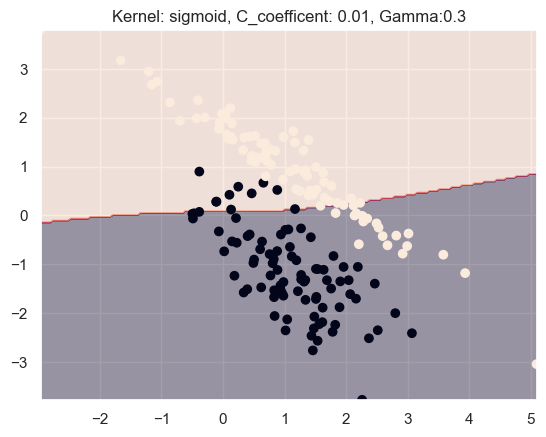

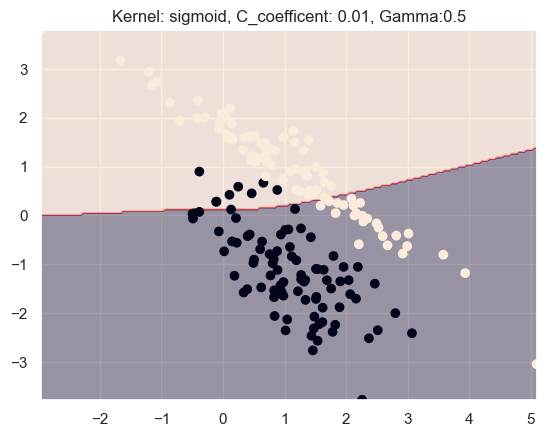

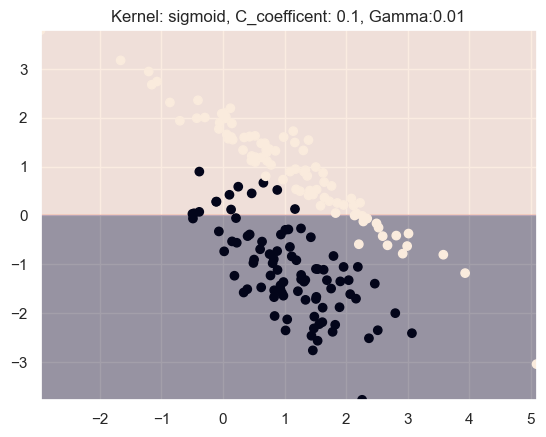

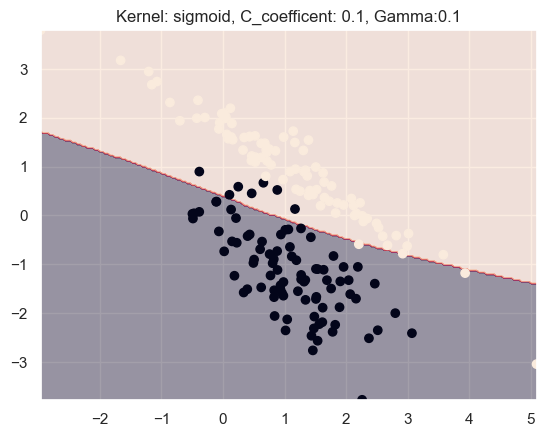

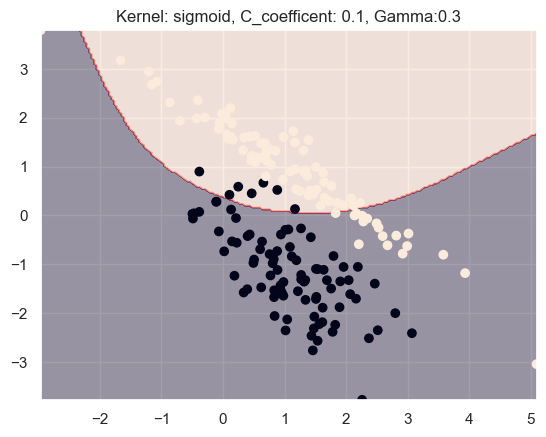

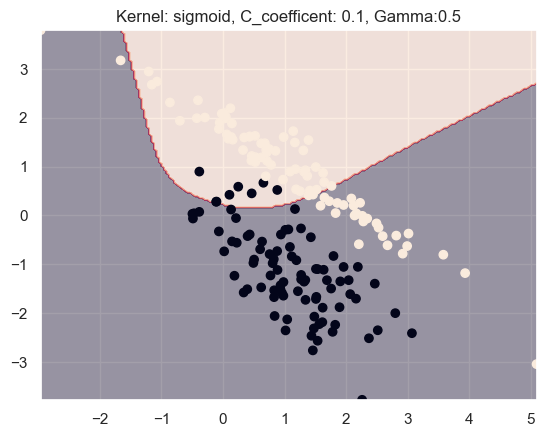

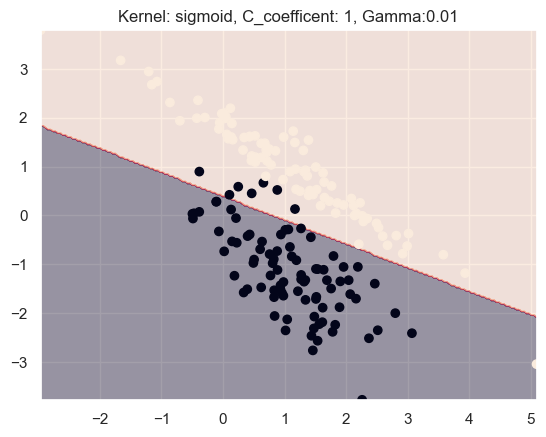

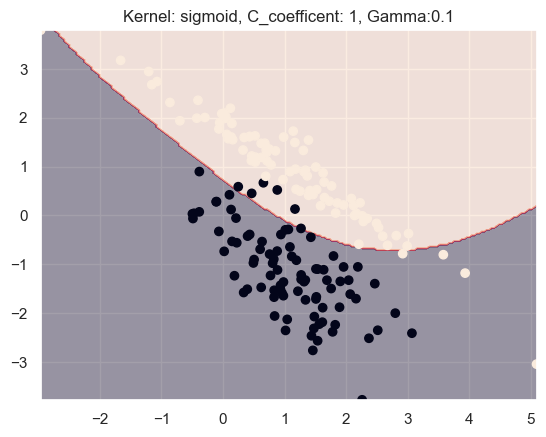

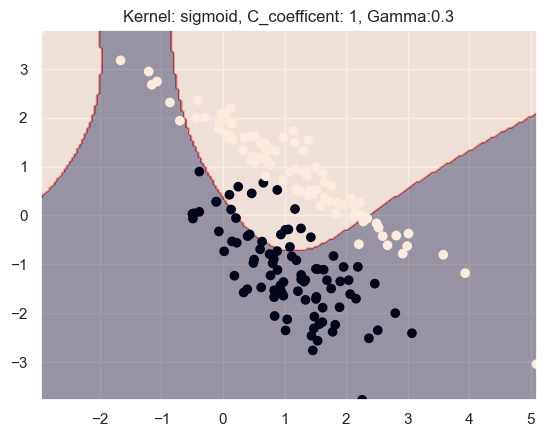

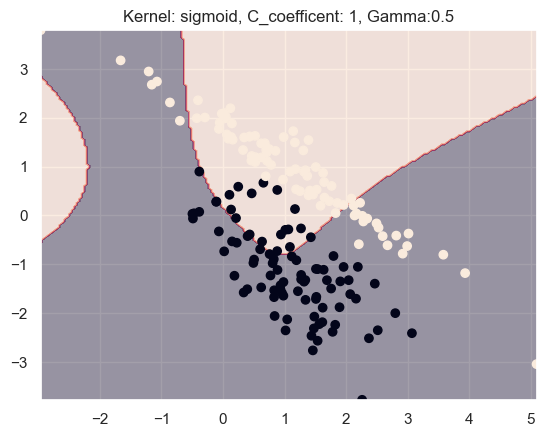

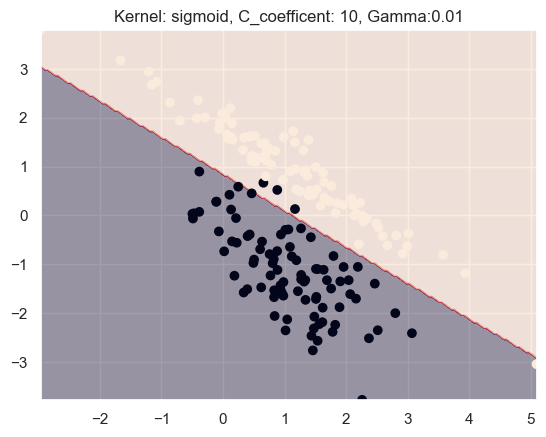

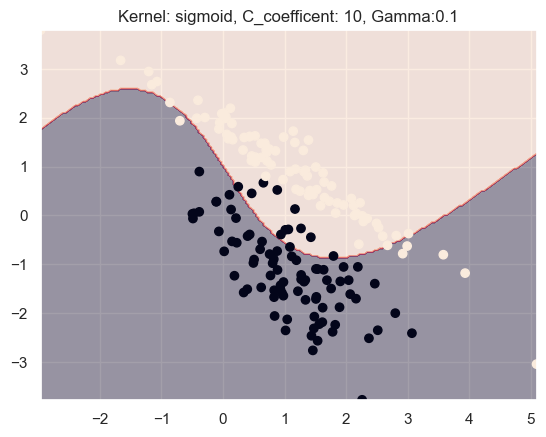

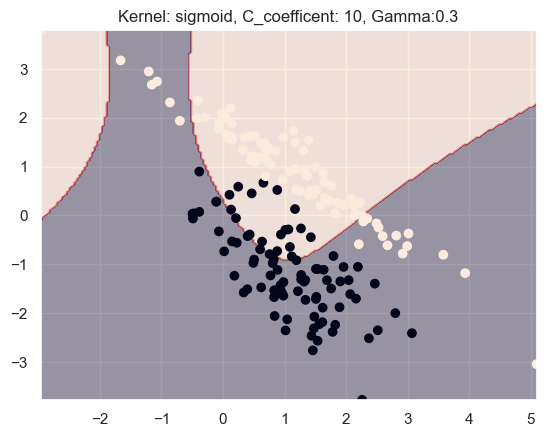

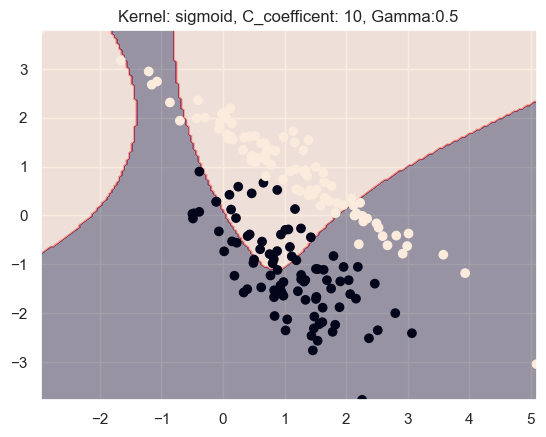

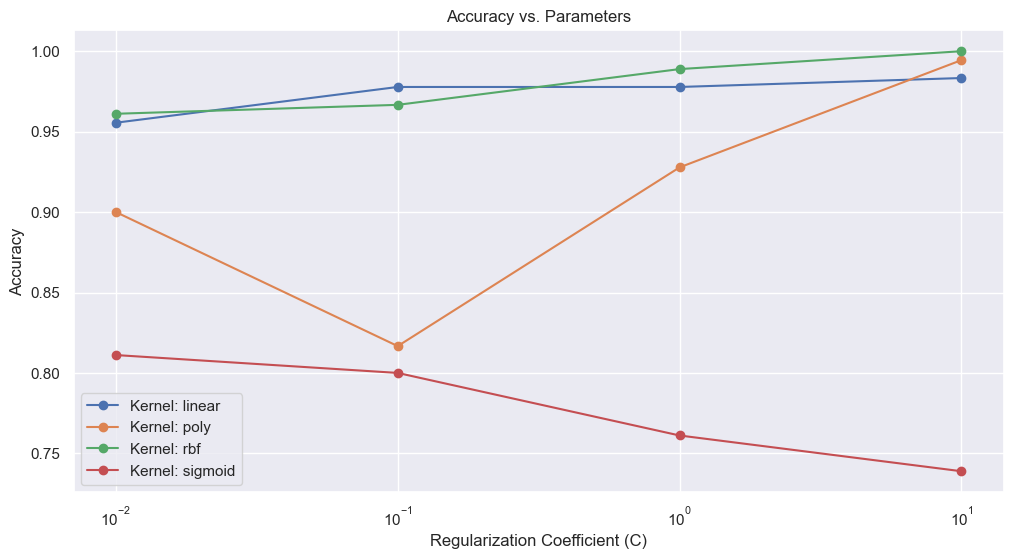

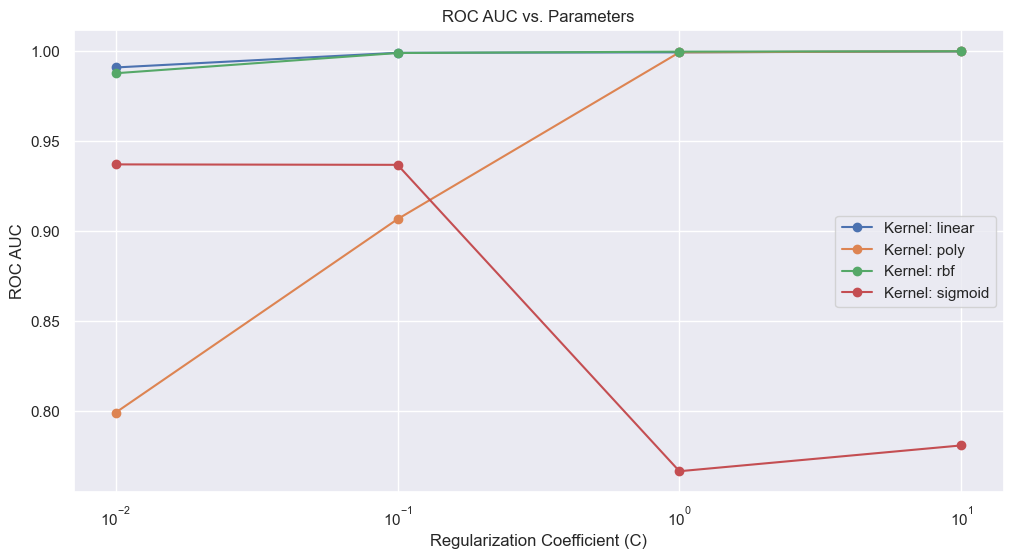

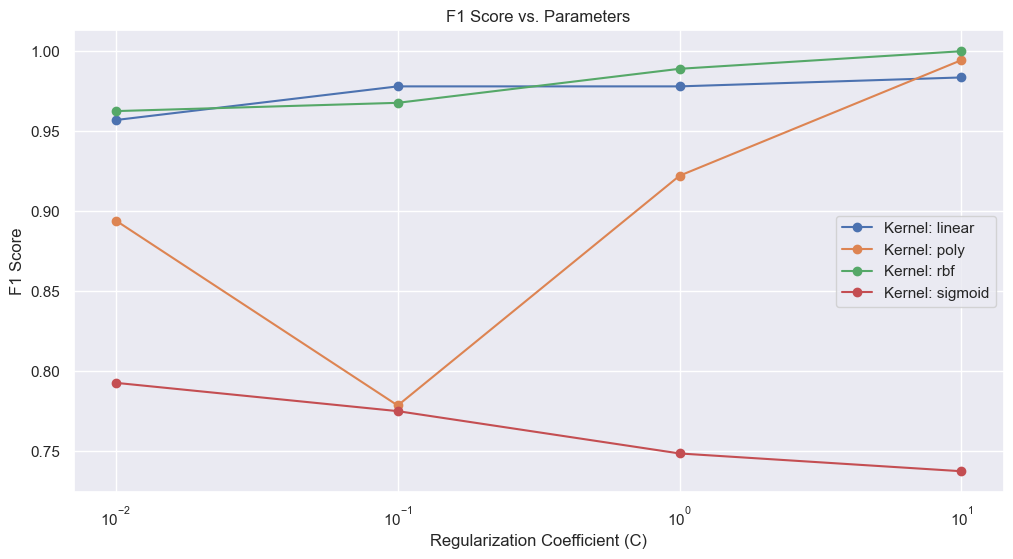

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Split the data into training and testing sets

# Define a range of hyperparameters to test
kernels = ['linear', 'poly', 'rbf','sigmoid']

C_values = [0.01,0.1,1,10]

degree_values = [1,2,3,5]

gamma_values = [0.01,0.1,0.3,0.5]

# Initialize lists to store evaluation metrics
accuracy_scores = []
roc_auc_scores = []
f1_scores = []


# Loop through different kernels and regularization coefficients
for kernel in kernels:
    for C in C_values:

        if(kernel == 'poly'):
            for degree in degree_values:
                svm = SVC(kernel=kernel, C=C, probability=True,degree=degree)
                svm.fit(X, y)
                # Make predictions on the test data
                y_pred = svm.predict(X)
                y_prob = svm.predict_proba(X)[:, 1]
                plot_decision_boundary_modified(svm,X,y,f'Kernel: {kernel}, C_coefficent: {C}, Degree:{degree}')
            # Calculate evaluation metrics
            accuracy = accuracy_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_prob)
            f1 = f1_score(y, y_pred)
            accuracy_scores.append((kernel, C, accuracy))
            roc_auc_scores.append((kernel, C, roc_auc))
            f1_scores.append((kernel, C, f1))
            continue
        if(kernel == 'rbf' or kernel == 'sigmoid'):
            for gamma in gamma_values:
                svm = SVC(kernel=kernel, C=C, probability=True,gamma=gamma)
                svm.fit(X, y)
                # Make predictions on the test data
                y_pred = svm.predict(X)
                y_prob = svm.predict_proba(X)[:, 1]
                plot_decision_boundary_modified(svm,X,y,f'Kernel: {kernel}, C_coefficent: {C}, Gamma:{gamma}')
            # Calculate evaluation metrics
            accuracy = accuracy_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_prob)
            f1 = f1_score(y, y_pred)
            accuracy_scores.append((kernel, C, accuracy))
            roc_auc_scores.append((kernel, C, roc_auc))
            f1_scores.append((kernel, C, f1))
            continue
        else:
            svm = SVC(kernel=kernel, C=C, probability=True)
            svm.fit(X, y)
            # Make predictions on the test data
            y_pred = svm.predict(X)
            y_prob = svm.predict_proba(X)[:, 1]
            plot_decision_boundary_modified(svm,X,y,f'Kernel: {kernel}, C_coefficent: {C}')
            # Calculate evaluation metrics
            accuracy = accuracy_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_prob)
            f1 = f1_score(y, y_pred)
            accuracy_scores.append((kernel, C, accuracy))
            roc_auc_scores.append((kernel, C, roc_auc))
            f1_scores.append((kernel, C, f1))
            continue       

# Create plots to visualize the results
def plot_metric(metric_scores, metric_name):
    plt.figure(figsize=(12, 6))
    plt.title(f"{metric_name} vs. Parameters")
    plt.xlabel("Regularization Coefficient (C)")
    plt.ylabel(metric_name)
    plt.xscale('log')
    plt.grid(True)
    for kernel in kernels:
        kernel_scores = [score for k, C, score in metric_scores if k == kernel]
        C_values = [C for k, C, score in metric_scores if k == kernel]
        plt.plot(C_values, kernel_scores, marker='o', label=f'Kernel: {kernel}')
    plt.legend()
    plt.show()

plot_metric(accuracy_scores, "Accuracy")
plot_metric(roc_auc_scores, "ROC AUC")
plot_metric(f1_scores, "F1 Score")

As we can see few parameters get us very low quality of hyperplane dividing, few of them overfitted model. RBF kernel divides plane pretty good, so I would prefer choose it further

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns
import pymorphy3 # Морфологический анализатор

from tqdm import tqdm_notebook
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
#from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
import string # for work with strings
import nltk
warnings.filterwarnings("ignore") 


Lets choose certain authors, leave only 6 directories and move them into our ipynb file directory, so then we get results below:  

# 1. Build

In [128]:
import os
import pandas as pd

columns = ['sentence','author']

sentences = pd.DataFrame(columns=columns)

def read_and_split_text_files(directory_path, delimiter='.'):
    # Get a list of all text files in the specified directory
    txt_files = [file for file in os.listdir(directory_path) if file.endswith(".txt")]

    # Initialize an empty list to store DataFrames

    dataframe = pd.DataFrame(columns=columns)

    # Loop through each text file and read its content into a DataFrame
    for txt_file in txt_files:
        file_path = os.path.join(directory_path, txt_file)
        # Read all lines from the file
        with open(file_path, 'r',encoding='utf8') as file:
            lines = file.read()

        lines = lines.replace("\t","")
        lines = lines.replace("\n","")

        # Create a DataFrame by splitting each line using the specified delimiter
        series = lines.split(delimiter)

        author = file_path.split("/")[2]

        df = pd.DataFrame({'sentence':series,'author':author})

        dataframe = pd.concat([dataframe,df])


    return dataframe

# Specify the directory path where your text files are located
directory_path = './prose/'

authors = ['Gogol','Tolstoy','Pushkin','Gorky','Dostoevsky','Bryusov']

for i in authors:
    path = directory_path + i + '/'
    temp_df = read_and_split_text_files(path)
    sentences = pd.concat([sentences,temp_df],ignore_index=True)



# Left only sentences which length are over 15 symbols
sentences = sentences[sentences['sentence'].apply(lambda x: len(str(x)) >= 15)]

# Display the resulting DataFrame

sentences['author'].value_counts()

author
Dostoevsky    88192
Tolstoy       86802
Gorky         38744
Bryusov       21530
Gogol         18502
Pushkin        9455
Name: count, dtype: int64

In [129]:
proportions = [5000, 15000, 8000, 11000, 20000, 3000]

# Create a new DataFrame to store the randomly chosen sentences
selected_sentences_df = pd.DataFrame(columns=['author', 'sentence'])

# Set a seed for reproducibility
np.random.seed(42)

# Iterate over each author and select sentences based on proportions
for author, proportion in zip(authors, proportions):
    author_sentences = sentences[sentences['author'] == author]['sentence'].tolist()
    selected_sentences = np.random.choice(author_sentences, size=proportion, replace=True)
    selected_sentences_df = pd.concat([pd.DataFrame({'author': [author] * proportion,
                                                                        'sentence': selected_sentences}),selected_sentences_df])

# Reset index of the new DataFrame
selected_sentences_df.reset_index(drop=True, inplace=True)

print(selected_sentences_df['author'].value_counts())



author
Dostoevsky    20000
Tolstoy       15000
Gorky         11000
Pushkin        8000
Gogol          5000
Bryusov        3000
Name: count, dtype: int64


# 2. Preprocess

In [173]:
# get russian stop words
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('russian')
punctuation = string.punctuation

word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
def process_data(data):
    texts = []


    for index, row in data.iterrows():
        text_lower = row['sentence'].lower()

        tokens = word_tokenizer.tokenize(text_lower)

        # check for punctuations, numbers and stop_words
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and not word.isnumeric())]
        
        texts.append(tokens)
    
    return texts


In [135]:
texts = process_data(selected_sentences_df)

In [144]:
morph = pymorphy3.MorphAnalyzer()


for i in range(len(texts)):           # tqdm_notebook creates the process bar below :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]]
    texts[i] = ' '.join(text_lemmatized)




In [153]:
from sklearn import preprocessing 

label = preprocessing.LabelEncoder()

selected_sentences_df['encoded_target']= label.fit_transform(selected_sentences_df['author'])

target = selected_sentences_df['encoded_target']

target.value_counts()


encoded_target
1    20000
5    15000
3    11000
4     8000
2     5000
0     3000
Name: count, dtype: int64

In [165]:
from sklearn.feature_extraction.text import CountVectorizer

train_texts, test_texts, train_y, test_y = train_test_split(texts, target, test_size=0.25)

vectorizer_bow = CountVectorizer(max_features = 50)

vectorizer_bow.fit(train_texts)

train_X_bow = vectorizer_bow.transform(train_texts)
test_X_bow  = vectorizer_bow.transform(test_texts)

vectorizer_bow.get_feature_names_out()[:10]

array(['бог', 'быть', 'ваш', 'весь', 'взять', 'видеть', 'время', 'всё',
       'глаз', 'говорить'], dtype=object)

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

vectorizer_tf_idf = TfidfVectorizer(max_features = 1000) # select the top 1000 words


vectorizer_tf_idf.fit(train_texts)

train_X_tf_idf = vectorizer_tf_idf.transform(train_texts)
test_X_tf_idf  = vectorizer_tf_idf.transform(test_texts)


vectorizer_tf_idf.get_feature_names_out()[:10]


array(['бог', 'быть', 'ваш', 'весь', 'взять', 'видеть', 'время', 'всякий',
       'всё', 'выйти'], dtype=object)

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [265]:
# From sixth seminar

def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [240]:
dataframe = pd.DataFrame([texts,target])

dataframe = dataframe.transpose()

dataframe.columns = ['sentence','author']

first_author = dataframe[dataframe['author'] == 0]
second_author = dataframe[dataframe['author'] == 2]

first_author['author'] = -1
second_author['author'] = 1

print(f'Author_1 size: {first_author.shape[0]}, Author_2 size:{second_author.shape[0]}')

dataset = pd.concat([first_author,second_author])


Author_1 size: 3000, Author_2 size:5000


In [241]:
dataset['author'].value_counts()

author
 1    5000
-1    3000
Name: count, dtype: int64

In [314]:
text_train, text_test, y_train, y_test = train_test_split(dataset['sentence'],dataset['author'],random_state=42,test_size=0.3)

vectorizer_tf_idf = TfidfVectorizer(max_features = 1000) # select the top 1000 words

vectorizer_tf_idf.fit(text_train)

train_X_tf_idf = vectorizer_tf_idf.transform(text_train)
test_X_tf_idf  = vectorizer_tf_idf.transform(text_test)

# SVM

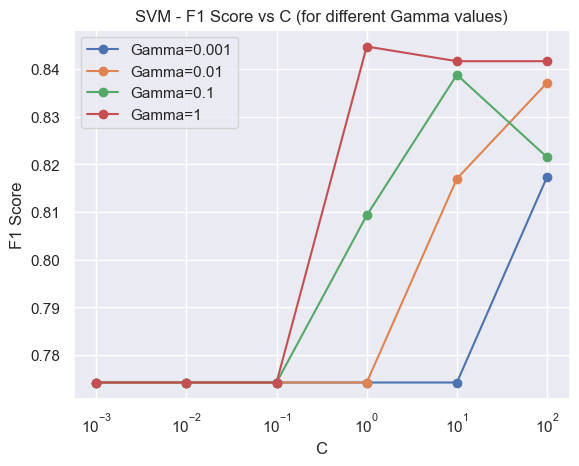

In [217]:
svm = SVC(probability=True)

svm_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

svm_grid = GridSearchCV(svm, svm_params, scoring='f1', cv=2)

svm_grid.fit(train_X_tf_idf, y_train)

svm_results = pd.DataFrame(svm_grid.cv_results_)
for gamma in svm_params['gamma']:
    plt.plot(svm_results[svm_results['param_gamma'] == gamma]['param_C'],
             svm_results[svm_results['param_gamma'] == gamma]['mean_test_score'],
             label=f'Gamma={gamma}', marker='o')
plt.title('SVM - F1 Score vs C (for different Gamma values)')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Confusion matrix and metric scores on best estimator for train and test:

Precision:   0.96
Recall:   0.93
F1-measure:   0.94
Accuracy:   0.95
ROC-AUC  =    0.97




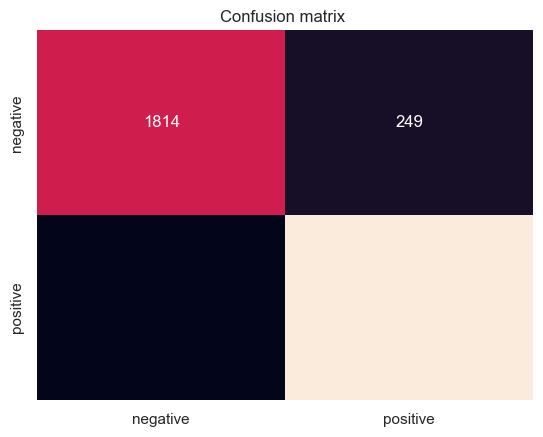

In [194]:
# Get the best estimator from the grid search
best_svc = svm_grid.best_estimator_

# Now, you can use the best SVC model to make predictions with probability estimates
probabilities = best_svc.predict_proba(train_X_tf_idf)
pred = best_svc.predict(train_X_tf_idf)

show_results(y_train,pred,probabilities)

Precision:   0.83
Recall:   0.78
F1-measure:   0.79
Accuracy:   0.81
ROC-AUC  =    0.89




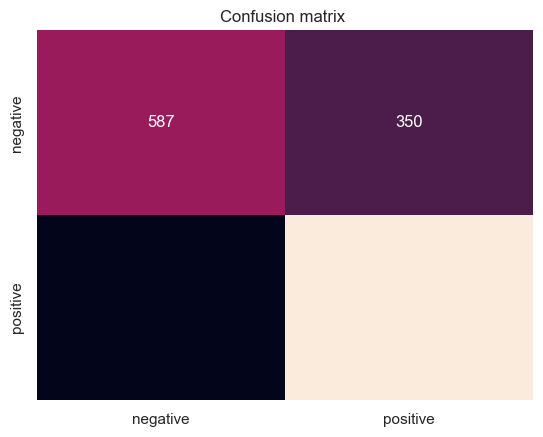

In [193]:
# Get the best estimator from the grid search
best_svc = svm_grid.best_estimator_

# Now, you can use the best SVC model to make predictions with probability estimates
probabilities = best_svc.predict_proba(test_X_tf_idf)
pred = best_svc.predict(test_X_tf_idf)

show_results(y_test,pred,probabilities)


So as we can see, we got a great results for our SVM model based on F1 measure and ROC-AUC curve

# Logistic Regression

Gridsearch wasnt working for inital model so instead of fixing base class I just wrote it on my own

In [343]:
condition = (dataset['author'] == -1)

# Change values in 'Column1' based on the condition
dataset.loc[condition, 'author'] = 0

text_train, text_test, y_train, y_test = train_test_split(dataset['sentence'],dataset['author'],random_state=42,test_size=0.3)

vectorizer_tf_idf = TfidfVectorizer(max_features = 1000) # select the top 100 words

vectorizer_tf_idf.fit(text_train)

train_X_tf_idf = vectorizer_tf_idf.transform(text_train)
test_X_tf_idf  = vectorizer_tf_idf.transform(text_test)

dataset['author'].value_counts()

train_X_tf_idf = train_X_tf_idf.toarray()
test_X_tf_idf = test_X_tf_idf.toarray() 
y_train = np.array(y_train)
y_test = np.array(y_test)


print(dataset['author'].value_counts())

type(train_X_tf_idf),type(test_X_tf_idf),type(y_train),type(y_test)

author
1    5000
0    3000
Name: count, dtype: int64


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [344]:
beta_values = [0.1, 0.5, 1.0]
learning_rates = [0.0001, 0.001,0.01, 0.1, 1.0]

best_f1 = 0
best_params = {}


results = []

for i,beta in enumerate(beta_values):
    results.append([])
    for learning_rate in learning_rates:
        model = Logit(beta=beta, lr=learning_rate)

        model.fit(train_X_tf_idf, y_train)

        y_pred = model.predict(test_X_tf_idf)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_params = {'beta': beta, 'learning_rate': learning_rate}

        results[i].append(f1)


best_params


{'beta': 0.1, 'learning_rate': 0.001}

Confusion matrix and metric scores on best estimator for train and test:

Precision:   0.85
Recall:   0.79
F1-measure:   0.80
Accuracy:   0.83
ROC-AUC  =    0.92




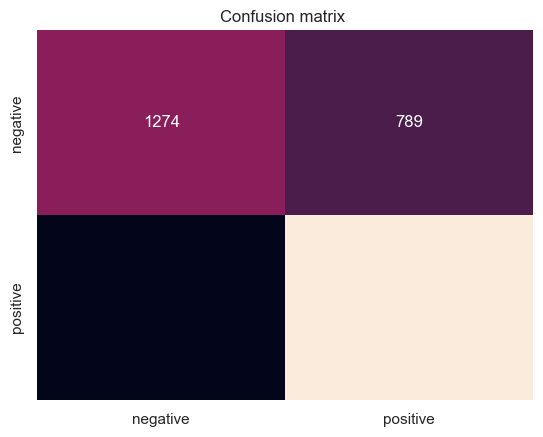

In [310]:
# Get the best estimator from the grid search
best_log_reg = Logit(beta = best_params['beta'],lr=best_params['learning_rate'])

best_log_reg.fit(train_X_tf_idf,y_train)

# Now, you can use the best SVC model to make predictions with probability estimates
probabilities = best_log_reg.predict_proba(train_X_tf_idf)
pred = best_log_reg.predict(train_X_tf_idf)

show_results(y_train,pred,probabilities)

Precision:   0.81
Recall:   0.74
F1-measure:   0.76
Accuracy:   0.79
ROC-AUC  =    0.88




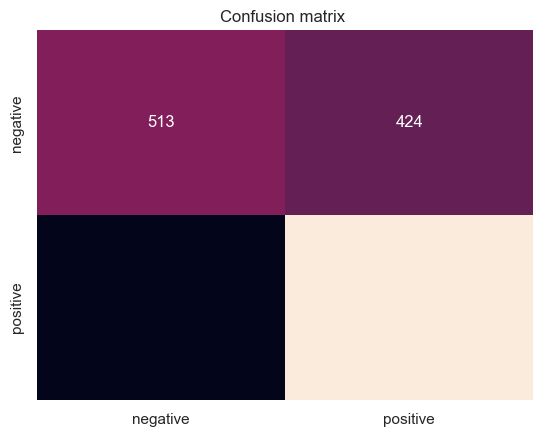

In [311]:
probabilities = best_log_reg.predict_proba(test_X_tf_idf)
pred = best_log_reg.predict(test_X_tf_idf)

show_results(y_test,pred,probabilities)


We got strong results for all metrics. The most significant metrics are F1 score and ROC-AUC and they both shows performance over 0.8 on the test. Considering the fact earlier we can make a conclusion of good fitted models. Also our self-made LogisticRegression shows almost the same result of a embeded model provided in sklearn library. 

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

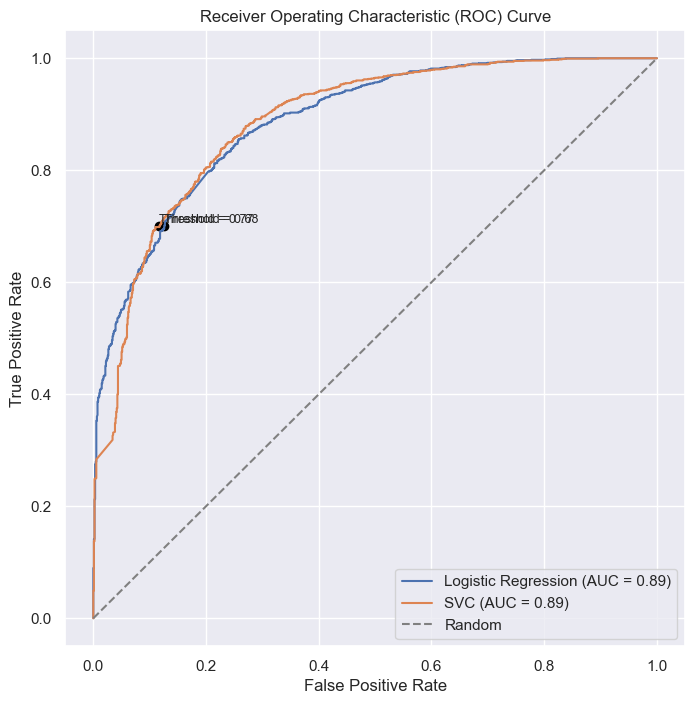

In [222]:
# Function to plot ROC curve with threshold
def plot_roc_curve(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    # Choose threshold such that false positive rate is no more than 30%
    threshold_index = np.argmax(tpr > 0.7)
    selected_threshold = thresholds[threshold_index]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
    plt.scatter(fpr[threshold_index], tpr[threshold_index], marker='o', color='black')
    plt.text(fpr[threshold_index], tpr[threshold_index], f'Threshold = {selected_threshold:.2f}', fontsize=9, verticalalignment='bottom')

# Plot ROC curves
plt.figure(figsize=(8, 8))

plot_roc_curve(best_log_reg, test_X_tf_idf, y_test, 'Logistic Regression')
plot_roc_curve(best_svc, test_X_tf_idf, y_test, 'SVC')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [339]:
train_texts, test_texts, y_train, y_test = train_test_split(texts, target, test_size=0.3)

vectorizer_tf_idf = TfidfVectorizer(max_features = 1000) # select the top 1000 words

vectorizer_tf_idf.fit(train_texts)

X_train = vectorizer_tf_idf.transform(train_texts)
X_test  = vectorizer_tf_idf.transform(test_texts)

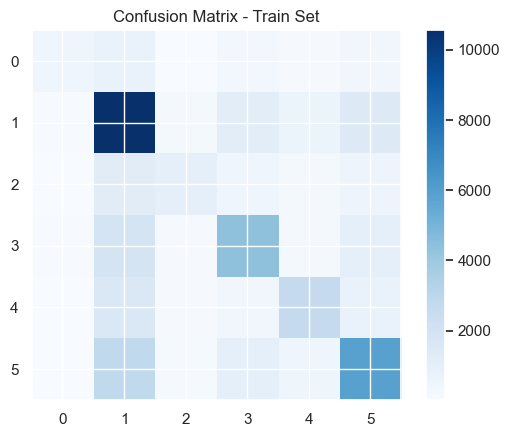

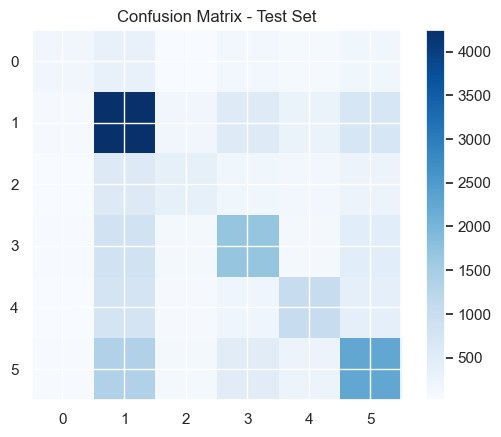

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.47      0.18      0.26       915
           1       0.52      0.71      0.60      5971
           2       0.45      0.24      0.32      1508
           3       0.53      0.52      0.52      3246
           4       0.54      0.42      0.47      2434
           5       0.53      0.50      0.52      4526

    accuracy                           0.52     18600
   macro avg       0.51      0.43      0.45     18600
weighted avg       0.52      0.52      0.51     18600



In [341]:
base_model = LogisticRegression(penalty='l2', C=0.5)  # Use your parameters here

# Create the One-VS-One classifier
ovo_classifier = OneVsOneClassifier(base_model)



param_grid = {'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Specify parameter grid for GridSearchCV
grid_search = GridSearchCV(ovo_classifier, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.show()

# Train set
y_train_pred = grid_search.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, title='Confusion Matrix - Train Set')

# Test set
y_test_pred = grid_search.predict(X_test)
plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix - Test Set')


print("Classification Report - Test Set:")
print(classification_report(y_test, y_test_pred))

